# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D, BatchNormalization
from tensorflow.keras import regularizers

2021-10-06 14:29:11.343312: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Data loading

Some settings

In [2]:
seed = 2021
dataset_path =  "../input/intel-image-classification/seg_train/seg_train/"
test_dataset_path = "../input/intel-image-classification/seg_test/seg_test/"
num_classes = 6

validation_split = 0.15
width = 150
height = 150
num_batches = 16
learning_rate = 0.0001
epochs = 150

Lets create data generators to artificialy extend our database. We will use diffrent generator for validaton/prediction data

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    zoom_range = 0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    validation_split = validation_split,
)

In [4]:
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = validation_split,
)

In [5]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

Load data as flow

In [6]:
train_dataset = train_datagen.flow_from_directory(
    dataset_path, 
    batch_size = num_batches, 
    target_size = (width, height), 
    subset = "training", 
    seed = seed
)

validation_dataset = val_datagen.flow_from_directory(
    dataset_path, 
    batch_size = num_batches, 
    target_size = (width, height), 
    subset = "validation", 
    seed = seed
)

Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.


In [7]:
test_dataset = test_datagen.flow_from_directory(
    test_dataset_path, 
    batch_size = num_batches, 
    target_size = (width, height),
    seed = seed
)

Found 3000 images belonging to 6 classes.


# Model preparation

I am gonna use pretrained xception model and try to finetune it. Lets freeze core layers at first.

In [8]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False) #We dont include top, because we need our custom output
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, activation="softmax")(avg) #Softmax because of 6 classes
model = keras.Model(inputs=base_model.input, outputs=output)

#First freeze xception model parameters
for layer in base_model.layers:
  layer.trainable = False

2021-10-06 14:29:36.276228: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-06 14:29:36.279480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-06 14:29:36.316135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 14:29:36.316731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-06 14:29:36.316780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-06 14:29:36.347371: I tensorflow/stream_executor/platform/def

83689472/83683744 [==============================] - 1s 0us/step


Compile model

In [9]:
optimizer = keras.optimizers.Adam(learning_rate)
loss = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy","Recall", "Precision"])

Create early stopping to stop overfitting and model checkpoint to maximize validation dataset performance

In [10]:
checkpoints = keras.callbacks.ModelCheckpoint("mode.h5", monitor='val_accuracy', mode="max")
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode="max", patience=5)

# First model training

First train top layer

In [11]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[checkpoints, earlystop])

2021-10-06 14:29:40.918797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-06 14:29:40.923024: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/150


2021-10-06 14:29:43.543371: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-06 14:29:44.322368: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-06 14:29:44.351234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


746/746 [==============================] - 160s 203ms/step - loss: 1.1533 - accuracy: 0.5922 - recall: 0.2707 - precision: 0.7930 - val_loss: 0.5072 - val_accuracy: 0.8397 - val_recall: 0.7702 - val_precision: 0.8662
Epoch 2/150
746/746 [==============================] - 80s 107ms/step - loss: 0.5088 - accuracy: 0.8319 - recall: 0.7699 - precision: 0.8655 - val_loss: 0.4014 - val_accuracy: 0.8658 - val_recall: 0.8325 - val_precision: 0.8879
Epoch 3/150
746/746 [==============================] - 83s 112ms/step - loss: 0.4277 - accuracy: 0.8500 - recall: 0.8107 - precision: 0.8803 - val_loss: 0.3607 - val_accuracy: 0.8773 - val_recall: 0.8520 - val_precision: 0.8902
Epoch 4/150
746/746 [==============================] - 85s 113ms/step - loss: 0.3975 - accuracy: 0.8598 - recall: 0.8274 - precision: 0.8827 - val_loss: 0.3399 - val_accuracy: 0.8796 - val_recall: 0.8611 - val_precision: 0.8943
Epoch 5/150
746/746 [==============================] - 80s 107ms/step - loss: 0.3809 - accuracy: 0.

# First model evaluation

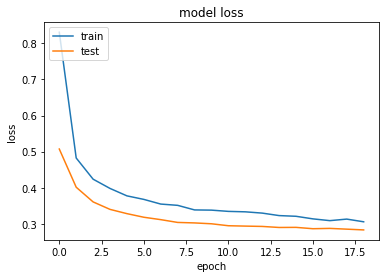

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

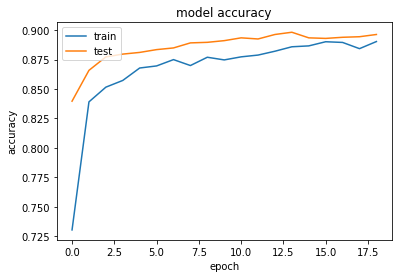

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
model.evaluate(validation_dataset)

132/132 [==============================] - 4s 27ms/step - loss: 0.2830 - accuracy: 0.8963 - recall: 0.8877 - precision: 0.9071


[0.28304681181907654,
 0.8962892293930054,
 0.8877259492874146,
 0.9071463346481323]

In [15]:
model.evaluate(train_dataset)

746/746 [==============================] - 81s 108ms/step - loss: 0.3060 - accuracy: 0.8885 - recall: 0.8748 - precision: 0.9010


[0.30602338910102844,
 0.8884512186050415,
 0.8747904896736145,
 0.9009926915168762]

In [16]:
model.evaluate(test_dataset)

188/188 [==============================] - 20s 105ms/step - loss: 0.2893 - accuracy: 0.8947 - recall: 0.8850 - precision: 0.9000


[0.2893335521221161,
 0.8946666717529297,
 0.8849999904632568,
 0.8999999761581421]

Preety good fair model with ~90% accuracy, which generalize well.

# Second model training

Let's try to finetune it on freezed xception layers now.
We need to use smaller learning rate, because otherwise we can lose, a lot of already trained informations.

In [17]:
#Unfreezing layers
for layers in base_model.layers:
    layers.trainable = True

In [18]:
#Smaller learning rate
optimizer = keras.optimizers.Adam(0.00001)
loss = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy","Recall", "Precision"])

In [19]:
history_finetune = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,callbacks=[checkpoints, earlystop])

Epoch 1/150
746/746 [==============================] - 115s 148ms/step - loss: 0.6785 - accuracy: 0.7638 - recall: 0.6407 - precision: 0.8548 - val_loss: 0.2986 - val_accuracy: 0.8953 - val_recall: 0.8806 - val_precision: 0.9056
Epoch 2/150
746/746 [==============================] - 125s 167ms/step - loss: 0.3933 - accuracy: 0.8649 - recall: 0.8320 - precision: 0.8887 - val_loss: 0.2555 - val_accuracy: 0.9110 - val_recall: 0.8977 - val_precision: 0.9209
Epoch 3/150
746/746 [==============================] - 107s 143ms/step - loss: 0.3505 - accuracy: 0.8730 - recall: 0.8504 - precision: 0.8938 - val_loss: 0.2333 - val_accuracy: 0.9182 - val_recall: 0.9129 - val_precision: 0.9253
Epoch 4/150
746/746 [==============================] - 110s 147ms/step - loss: 0.3152 - accuracy: 0.8884 - recall: 0.8716 - precision: 0.9060 - val_loss: 0.2244 - val_accuracy: 0.9210 - val_recall: 0.9139 - val_precision: 0.9280
Epoch 5/150
746/746 [==============================] - 109s 146ms/step - loss: 0.283

# Second model evaluation

In [20]:
model.evaluate(validation_dataset)

132/132 [==============================] - 4s 29ms/step - loss: 0.1996 - accuracy: 0.9348 - recall: 0.9315 - precision: 0.9391


[0.19963590800762177,
 0.9348239898681641,
 0.9314938187599182,
 0.9390887022018433]

In [21]:
model.evaluate(train_dataset)

746/746 [==============================] - 81s 109ms/step - loss: 0.0639 - accuracy: 0.9790 - recall: 0.9779 - precision: 0.9798


[0.06386047601699829,
 0.979047954082489,
 0.9778746366500854,
 0.9797632098197937]

In [22]:
model.evaluate(test_dataset)

188/188 [==============================] - 8s 44ms/step - loss: 0.2038 - accuracy: 0.9307 - recall: 0.9283 - precision: 0.9327


[0.20381760597229004,
 0.9306666851043701,
 0.9283333420753479,
 0.9326858520507812]

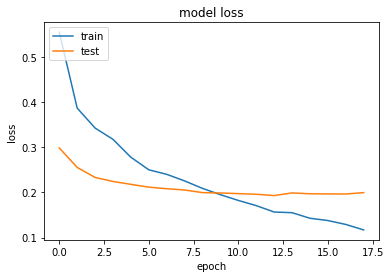

In [23]:
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

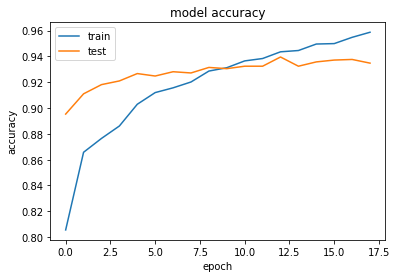

In [24]:
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()